In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

In [2]:
df_gene = pd.read_csv('./processed_data/clean_data/gene_expression_v10k.csv', index_col = 0)

In [3]:
df_meta = pd.read_csv('./processed_data/clean_data/metadata.csv', index_col = 0)

In [4]:
set(zip(df_meta.pid, df_meta.is_covid))

{('set1-A', 0),
 ('set1-B', 0),
 ('set2-A', 0),
 ('set2-B', 0),
 ('set3-A', 0),
 ('set3-B', 0),
 ('set4-A', 0),
 ('set4-B', 0),
 ('set5-A', 1),
 ('set5-B', 1),
 ('set6-A', 1),
 ('set6-B', 1),
 ('set7-A', 1),
 ('set7-B', 1),
 ('set8-A', 1),
 ('set8-B', 1),
 ('set9-A', 1),
 ('set9-B', 1)}

In [5]:
id2pid = sorted(set(df_meta.pid))

In [6]:
id2pid

['set1-A',
 'set1-B',
 'set2-A',
 'set2-B',
 'set3-A',
 'set3-B',
 'set4-A',
 'set4-B',
 'set5-A',
 'set5-B',
 'set6-A',
 'set6-B',
 'set7-A',
 'set7-B',
 'set8-A',
 'set8-B',
 'set9-A',
 'set9-B']

In [ ]:
from collections import Counter
from itertools import combinations

res_all = {}

for t, tids in [('PFC', [1, 2]), 
            ('medulla', [3, 4]),
            ('choroid plexus', [5, 6]),
           ]:
    res0 = {}
    for it, tid in enumerate(tids):
        for i, j in combinations(id2pid, r = 2):
            v0 = df_gene[(df_meta.pid == i) & (df_meta.tissue_id == tid)]
            v1 = df_gene[(df_meta.pid == j) & (df_meta.tissue_id == tid)]
            res = [ranksums(v0[g].values, v1[g].values) for g in v0.columns]
            pval = [r[1] for r in res]
            fdr = multipletests(pval, method = 'fdr_bh', alpha = 0.05)
            res0[(i, j, it)] = sum(fdr[0])
    res_all[t] = res0
    

In [40]:
df_gene.shape

(68557, 10000)

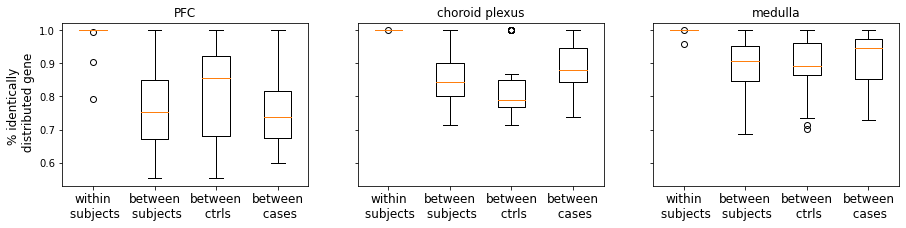

In [54]:
fig, axes = plt.subplots(1, 3, figsize = (15, 3), sharey = True)
for it, t in enumerate(sorted(res_all)):
    res0 = res_all[t]
    within = [1 - res0[('set%d-A' % i, 'set%d-B' % i, 0)] / 10000 for i in range(1, 10)] 
    within += [1 - res0[('set%d-A' % i, 'set%d-B' % i, 1)] / 10000 for i in range(1, 10)] 
    between_all = [1 - res0[(i, j, 0)] / 10000 for i, j in combinations(id2pid, r = 2)] 
    between_all += [1 - res0[(i, j, 1)] / 10000 for i, j in combinations(id2pid, r = 2)]
    between_ctrl = [1 - res0[(i, j, 0)] / 10000 for i, j in combinations(id2pid[:8], r = 2)] 
    between_ctrl += [1 - res0[(i, j, 1)] / 10000 for i, j in combinations(id2pid[:8], r = 2)]
    between_case = [1 - res0[(i, j, 0)] / 10000 for i, j in combinations(id2pid[8:], r = 2)] 
    between_case += [1 - res0[(i, j, 1)] / 10000 for i, j in combinations(id2pid[8:], r = 2)]
    
    tmp = [within, between_all, between_ctrl, between_case]
    plt.sca(axes[it])
    plt.boxplot(tmp)
    plt.xticks([1, 2, 3, 4], 
               ['within\n subjects', 
                'between\n subjects',
                'between\n ctrls', 
                'between\n cases'], 
               fontsize = 12)
    plt.title(t)
    if it == 0:
        plt.ylabel('% identically \n distributed gene', fontsize = 12)

plt.savefig('figs/qc_gene_repeat.pdf', bbox_inches='tight')
plt.savefig('figs/png/qc_gene_repeat.png', dpi = 600, bbox_inches='tight')

plt.show()

In [73]:
import pickle
with open('qc_gene_repeat_res.p', 'wb') as writer:
    pickle.dump(res_all, writer)

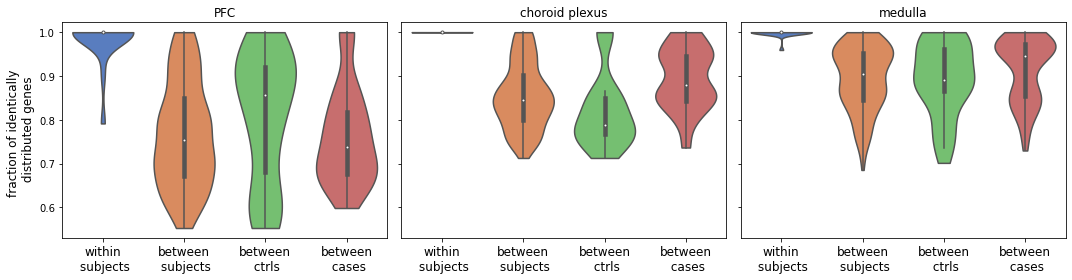

In [72]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize = (15, 4), sharey = True)

for it, t in enumerate(sorted(res_all)):
    res0 = res_all[t]
    within = [1 - res0[('set%d-A' % i, 'set%d-B' % i, 0)] / 10000 for i in range(1, 10)] 
    within += [1 - res0[('set%d-A' % i, 'set%d-B' % i, 1)] / 10000 for i in range(1, 10)] 
    between_all = [1 - res0[(i, j, 0)] / 10000 for i, j in combinations(id2pid, r = 2)] 
    between_all += [1 - res0[(i, j, 1)] / 10000 for i, j in combinations(id2pid, r = 2)]
    between_ctrl = [1 - res0[(i, j, 0)] / 10000 for i, j in combinations(id2pid[:8], r = 2)] 
    between_ctrl += [1 - res0[(i, j, 1)] / 10000 for i, j in combinations(id2pid[:8], r = 2)]
    between_case = [1 - res0[(i, j, 0)] / 10000 for i, j in combinations(id2pid[8:], r = 2)] 
    between_case += [1 - res0[(i, j, 1)] / 10000 for i, j in combinations(id2pid[8:], r = 2)]
    
    df_plot = pd.DataFrame(within + between_all + between_ctrl + between_case, columns = ['gene'])
    tmp = ['within\n subjects'] * len(within) + ['between\n subjects'] * len(between_all) 
    tmp += ['between\n ctrls'] * len(between_ctrl) + ['between\n cases'] * len(between_case)
    df_plot['cond'] = tmp
    
    ax = axes[it]
    ax = sns.violinplot(y="gene", x="cond", scale = 'width',
                        data=df_plot, palette="muted", cut = 0, 
                        ax = ax, width = .75)
    plt.sca(ax)
    plt.title(t, fontsize = 12)
    plt.ylabel('')
    plt.xlabel('')
    
    plt.xticks(fontsize = 12)
    
    plt.xticks(range(4), 
               ['within\n subjects', 
                'between\n subjects',
                'between\n ctrls', 
                'between\n cases'], 
               fontsize = 12)
    plt.title(t)
    if it == 0:
        plt.ylabel('fraction of identically \n distributed genes', fontsize = 12)

plt.tight_layout()
plt.savefig('figs/qc_gene_repeat.pdf', bbox_inches='tight')
plt.savefig('figs/png/qc_gene_repeat.png', dpi = 600, bbox_inches='tight')

plt.show()